In [ ]:
# ! pip install langchain

In [24]:
import nltk
import re
import gensim
import matplotlib.pyplot as plt
import pandas as pd
import logging
import warnings
import numpy as np
import seaborn as sns
from typing import Optional
import tqdm
import time
import psutil
import os
from typing import Optional


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = 'white'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
%matplotlib inline

## config.py

In [4]:
# Global Configuration for Gensim Bigrams
class CONFIG:
    def __init__(self):
        self.MIN_COUNT = 20
        self.THRESHOLD = 10
        self.NO_BELOW = 5
        self.NO_ABOVE = 0.95

        # Global Configuration for Gensm LDA
        self.CHUNKSIZE = 1700 #2000
        self.ITERATIONS = 80 #100
        self.PASSES = 15 #20 # epochs
cfg = CONFIG()

## topic_modling.py
### scripts

In [5]:
def normalize_corpus(conversations):
    """
    Normalize the corpus by converting to lowercase, removing special entities,
    tokenizing, lemmatizing, and removing stopwords.

    Parameters:
    conversations (list): List of conversations to be normalized.

    Returns:
    list: List of normalized conversations.
    """
    stop_words = nltk.corpus.stopwords.words('english')
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    norm_conversations = []

    print("Normalizing conversations: ")
    for conversation in tqdm.tqdm(conversations):
        conversation = conversation.lower()
        conversation = re.sub(r'\{\{.*?\}\}', '', conversation)
        conversation_tokens = [token.strip() for token in tokenizer.tokenize(conversation)]
        conversation_tokens = [lemmatizer.lemmatize(token) for token in conversation_tokens if not token.isnumeric()]
        conversation_tokens = [token for token in conversation_tokens if len(token) > 1]
        conversation_tokens = [token for token in conversation_tokens if token not in stop_words]
        conversation_tokens = list(filter(None, conversation_tokens))
        if conversation_tokens:
            norm_conversations.append(conversation_tokens)

    return norm_conversations


def gensim_build_bigrams_bow(norm_conversations):
    """
    Build bigrams and Bag of Words representation of the normalized conversations.

    Parameters:
    norm_conversations (list): List of normalized conversations.

    Returns:
    tuple: Tuple containing the Bag of Words corpus, dictionary, and conversations with bigrams.
    """
    bigram = gensim.models.Phrases(norm_conversations, min_count=cfg.MIN_COUNT, threshold=cfg.THRESHOLD, delimiter='_')
    bigram_model = gensim.models.phrases.Phraser(bigram)
    norm_conversations_bigrams = [bigram_model[conversation] for conversation in norm_conversations]
    dictionary = gensim.corpora.Dictionary(norm_conversations_bigrams)
    dictionary.filter_extremes(no_below=cfg.NO_BELOW, no_above=cfg.NO_ABOVE)
    bow_corpus = [dictionary.doc2bow(text) for text in norm_conversations_bigrams]

    return bow_corpus, dictionary, norm_conversations_bigrams

def topic_modeling_by_coherence(bow_corpus, conversations, dictionary, start_topic_count=2, end_topic_count=10, step=1):
    """
    Perform topic modeling and evaluate using coherence scores.

    Parameters:
    bow_corpus (list): Bag of Words corpus.
    conversations (list): Conversations with bigrams.
    dictionary (gensim.corpora.Dictionary): Gensim dictionary.
    start_topic_count (int): Starting number of topics.
    end_topic_count (int): Ending number of topics.
    step (int): Step size for the number of topics.

    Returns:
    tuple: Tuple containing the LDA models, coherence dataframe, and coherence plot.
    """
    lda_models = []
    scores = {"coherence_c_v_scores": [], "coherence_umass_scores": [], "perplexity_scores": [], "warnings": []}

    gensim_logger = logging.getLogger('gensim')
    gensim_logger.setLevel(logging.ERROR)

    print("Fitting the n-topics iteration: ")
    for num_topics in tqdm.tqdm(range(start_topic_count, end_topic_count + 1, step)):
        with warnings.catch_warnings(record=True) as caught_warnings:
            warnings.simplefilter("always")
            lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=cfg.CHUNKSIZE,
                                               alpha='auto', eta='auto', random_state=7, iterations=cfg.ITERATIONS,
                                               num_topics=num_topics, passes=cfg.PASSES, eval_every=None)
            lda_models.append(lda_model)

            # Coherence and perplexity evaluations
            cv_coherence = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, texts=conversations,
                                                        dictionary=dictionary, coherence='c_v').get_coherence()
            scores["coherence_c_v_scores"].append(cv_coherence)

            umass_coherence = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, texts=conversations,
                                                           dictionary=dictionary, coherence='u_mass').get_coherence()
            scores["coherence_umass_scores"].append(umass_coherence)

            perplexity = lda_model.log_perplexity(bow_corpus)
            scores["perplexity_scores"].append(perplexity)

            # Capture warnings
            warning_message = [str(warning.message) for warning in caught_warnings if "updated prior is not positive" in str(warning.message)]
            scores["warnings"].append(warning_message[0] if warning_message else None)

    # Dataframe for coherence scores
    coherence_df = pd.DataFrame({
        'Number of Topics': range(start_topic_count, end_topic_count + 1, step),
        'C_v Score': np.round(scores["coherence_c_v_scores"], 4),
        'UMass Score': np.round(scores["coherence_umass_scores"], 4),
        'Perplexity Score': np.round(scores["perplexity_scores"], 4),
        'Warnings': scores["warnings"]
    })

    return lda_models, coherence_df

## optibot_modeling.py

In [67]:
class OptiBotModeling:
    def __init__(self,
                 df: pd.DataFrame,
                 context: str = "chatbot conversations",
                 start_topic_count: int = 3,
                 end_topic_count: int = 10,
                 step: int = 1):

        self.df_conversation = df["conversation"].to_list()
        self.context: Optional[str] = context
        self.start_topic_count = int(start_topic_count)
        self.end_topic_count = int(end_topic_count)
        self.step = int(step)
        self._best_lda_model = None
        self._bow_corpus = None
        self._norm_conversations_bigrams = None
        self._topics_df: Optional[pd.DataFrame] = None
        self._topics_df_as_list: Optional[pd.DataFrame] = None
        self._coherence_df: Optional[pd.DataFrame] = None
        self._corpus_topic_df: Optional[pd.DataFrame] = None
        self.best_number_topics = None
        self.best_coherence_score = None
        self.execution_time = None
        self.resource_usage = None


    def fit(self):
        start_time = time.time()
        initial_memory_use = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

        norm_conversations = normalize_corpus(self.df_conversation)
        self._bow_corpus, dictionary, self._norm_conversations_bigrams = gensim_build_bigrams_bow(norm_conversations)

        lda_models, self._coherence_df = topic_modeling_by_coherence(
            bow_corpus=self._bow_corpus,
            conversations=self._norm_conversations_bigrams,
            dictionary=dictionary,
            start_topic_count=self.start_topic_count,
            end_topic_count=self.end_topic_count
        )

        best_model_idx = self._coherence_df['C_v Score'].idxmax()
        self._best_lda_model = lda_models[best_model_idx]
        self.best_number_topics = self._coherence_df['Number of Topics'].iloc[best_model_idx]
        self.best_coherence_score = self._coherence_df['C_v Score'].iloc[best_model_idx]

        lda_models = None # <-- Garbage collection
        self._fit_topics_on_data()

        end_memory_use = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        self.execution_time = round(time.time() - start_time, 3)
        self.resource_usage = round(end_memory_use - initial_memory_use, 3)  # in MB

    def _fit_topics_on_data(self):
        # Check if the model is fitted
        if self._best_lda_model is None:
            raise ValueError("Model not fitted. Call 'fit' before this method.")

        # Topic term extraction and dataframe creation
        topics = [[(term, round(wt, 3))
                    for term, wt in self._best_lda_model.show_topic(n, topn=20)]
                        for n in range(0, self._best_lda_model.num_topics)]

        self._topics_df = pd.DataFrame([', '.join([term for term, wt in topic])
                                  for topic in topics],
                             columns=['Terms per Topic'],
                             index=['Topic'+str(t) for t in range(1, self._best_lda_model.num_topics+1)]
                             )


        self._topics_df_as_list = pd.DataFrame([[topic] for topic in [[term for term, wt in topic] for topic in topics]],
                                  columns=['Terms per Topic'],
                                  index=['Topic'+str(t) for t in range(1, self._best_lda_model.num_topics+1)])

        tm_results = self._best_lda_model[self._bow_corpus]
        corpus_topics = [sorted(topics, key=lambda record: -record[1])[0]
                            for topics in tm_results]

        # Integrate topic modeling results into original conversations
        self._corpus_topic_df = pd.DataFrame()
        self._corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
        self._corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
        self._corpus_topic_df['Topic Desc'] = [self._topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
        self._corpus_topic_df['Conversation'] = self.df_conversation

    def show_coherence_plot(self, save=False):
        if self.coherence_df is None:
            raise ValueError("Topics not generated. Call 'fit' to generate topics.")

        # Extract the coherence scores and compute the highest point
        coherence_scores = self.coherence_df["C_v Score"]
        max_score_index = coherence_scores.idxmax()
        max_score = coherence_scores[max_score_index]
        max_score_topic = self.start_topic_count + self.step * max_score_index

        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 6))
        x_values = range(self.start_topic_count, self.end_topic_count + 1, self.step)
        ax.plot(x_values, coherence_scores, c='r')
        ax.axhline(y=0.5, c='k', linestyle='--', linewidth=2)
        ax.set_xlabel('Number of Topics')
        ax.set_ylabel('Coherence C_v Score')
        ax.set_title('Topic Coherence')
        ax.set_facecolor('#f0f0f0')
        fig.patch.set_facecolor('white')
        ax.grid(True)

        # Highlight the highest point
        ax.scatter(max_score_topic, max_score, s=500, edgecolors='blue', facecolors='none', linewidths=5, zorder=5) #color='blue',

        if save:
            fig.savefig('coherence_plot.png', bbox_inches='tight')

        #return fig

    @property
    def topics_df(self) -> pd.DataFrame:
        if self._topics_df is None:
            raise ValueError("Topics not generated. Call 'fit' to generate topics.")
        return self._topics_df

    @property
    def topics_df_as_list(self) -> pd.DataFrame:
        if self._topics_df is None:
            raise ValueError("Topics not generated. Call 'fit' to generate topics.")
        return self._topics_df_as_list

    @property
    def corpus_topic_df(self) -> pd.DataFrame:
        if self._corpus_topic_df is None:
            raise ValueError("Corpus topic not generated. Call 'fit' to generate corpus topics.")
        return self._corpus_topic_df

    @property
    def coherence_df(self) -> pd.DataFrame:
        if self._coherence_df is None:
            raise ValueError("Corpus topic not generated. Call 'fit' to generate corpus topics.")
        return self._coherence_df

    @property
    def coherence_plot(self) -> pd.DataFrame:
        if self._coherence_plot is None:
            raise ValueError("Corpus topic not generated. Call 'fit' to generate corpus topics.")
        return self._coherence_plot

## load_data.py
### script

In [7]:
def merge_multiple_qa_columns(df, question_cols, answer_cols):
    df['conversation'] = "Question: " + df[question_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1) + " Answer: " + df[answer_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    return df

def extract_unified_column(df, col):
    df["conversation"] = df[col]
    return df

## Medical Data

In [8]:
! pip install --quiet datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


In [9]:
from datasets import load_dataset

dataset = load_dataset("ruslanmv/ai-medical-chatbot")
medical_ai_df = dataset['train'].to_pandas()

Generating train split:   0%|          | 0/256916 [00:00<?, ? examples/s]

In [10]:
medical_ai_df["conversation"] = "Question: " + medical_ai_df["Description"] + " " + medical_ai_df["Patient"] + " Answer: " + medical_ai_df["Doctor"]

In [69]:
medical_ai_topics = OptiBotModeling(medical_ai_df.sample(10000), start_topic_count=5, end_topic_count=17)

In [70]:
%%time
medical_ai_topics.fit()

Normalizing conversations: 


100%|██████████| 10000/10000 [00:14<00:00, 678.93it/s]


Fitting the n-topics iteration: 


100%|██████████| 13/13 [12:20<00:00, 56.97s/it]


CPU times: user 12min 32s, sys: 5.23 s, total: 12min 37s
Wall time: 12min 47s


In [25]:
medical_ai_topics.topics_df.head(3)

,Terms per Topic
Topic1,"baby, child, ha, stool, question, son, answer_..."
Topic2,"help, anxiety, time, feel, get, hand, like, li..."
Topic3,"infection, fever, antibiotic, day, ha, wa, doc..."


In [26]:
medical_ai_topics.topics_df.tail(3)

,Terms per Topic
Topic14,"long, treatment, take, question, problem, day,..."
Topic15,"test, kidney, urine, blood, report, normal, in..."
Topic16,"lump, surgery, left, right, cyst, answer_hi, q..."


In [27]:
medical_ai_topics.corpus_topic_df.sample(3)

,Dominant Topic,Contribution %,Topic Desc,Conversation
8258,9,47.09,"pain, wa, back, get, day, could, due, also, li...",NaN
6102,9,31.90,"pain, wa, back, get, day, could, due, also, li...",NaN
7864,7,30.72,"wa, heart, level, cause, normal, high, also, q...",NaN


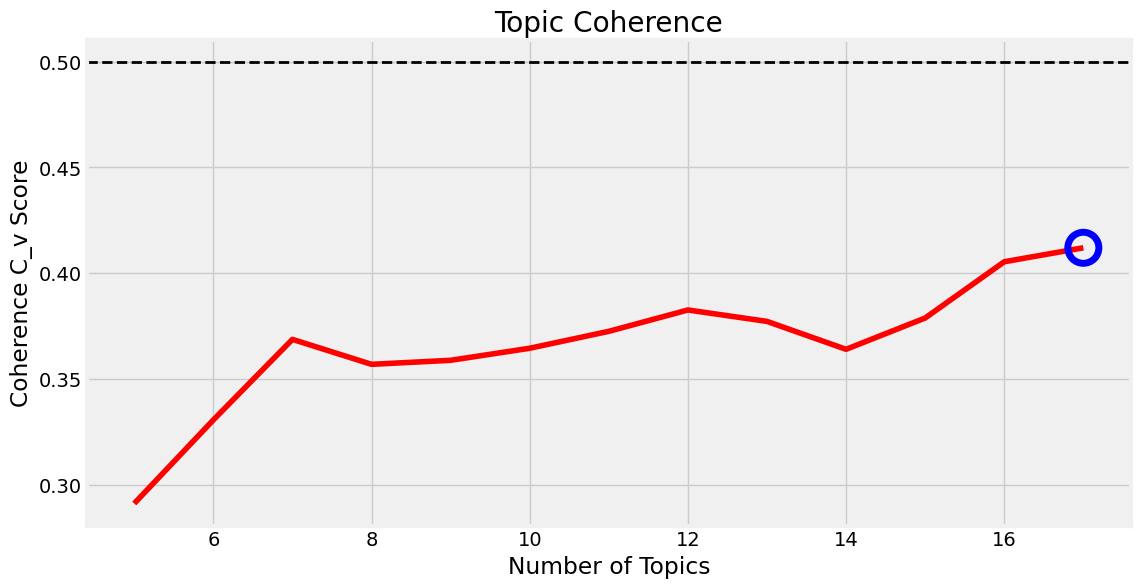

In [72]:
medical_ai_topics.show_coherence_plot()

## Load Data and Extract Topics - Bitext

In [29]:
bitext_df = pd.read_csv("https://raw.githubusercontent.com/bitext/customer-support-llm-chatbot-training-dataset/main/data/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv")

In [30]:
bitext_df = merge_multiple_qa_columns(bitext_df, ["instruction"], ["response"])
print(bitext_df.shape)

(26872, 6)


In [31]:
bitext_topics = OptiBotModeling(bitext_df, start_topic_count=4, end_topic_count=14)

In [32]:
%%time
bitext_topics.fit()

Normalizing conversations: 


100%|██████████| 26872/26872 [00:21<00:00, 1254.51it/s]


Fitting the n-topics iteration: 


100%|██████████| 11/11 [15:50<00:00, 86.45s/it]


CPU times: user 16min 14s, sys: 11.3 s, total: 16min 25s
Wall time: 16min 26s


In [33]:
bitext_topics.corpus_topic_df.sample(5)

,Dominant Topic,Contribution %,Topic Desc,Conversation
15561,1,51.27,"provide, information, please, help, detail, as...",Question: i have to download the bill from {{P...
16848,4,38.46,"feedback, support, team, customer, rebate, ser...",Question: I want assistance to ask for rebates...
10312,10,55.43,"address, option, section, step, look, please, ...",Question: where do i open a gold account for m...
1383,1,59.42,"provide, information, please, help, detail, as...",Question: I'd like to add a prdouct to purchas...
8817,4,47.56,"feedback, support, team, customer, rebate, ser...",Question: how can I check what hours I can cal...


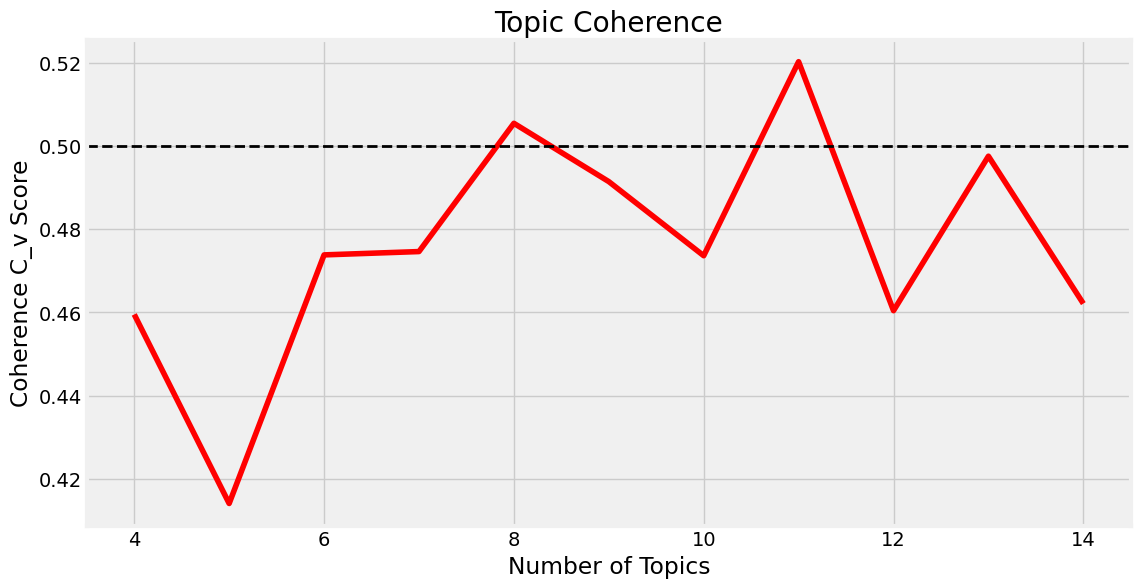

In [34]:
bitext_topics.show_coherence_plot()

## LLM Topic Labeling

In [76]:
! pip install --quiet openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00


In [77]:
import os
from openai import OpenAI
from google.colab import userdata


def create_openai_client(api_key):
    client = OpenAI(api_key=api_key)
    return client

### Simple prompting

In [115]:
## First prompt
def generate_topic_labels(client, topics_keywords, context="chatbot conversations"):
    system_prompt = (
        "You are designed to generate concise labels for topics. "
        "These topics are derived from chatbot conversations about {context} using LDA (Latent Dirichlet Allocation). "
        "Your task is to provide a single, pertinent label for each set of keywords representing a topic, "
        "ensuring the label accurately reflects the {context} context of the conversation."
    ).format(context=context)


    topic_labels = {}
    for topic, keywords in topics_keywords.items():
        prompt = f"Based on these keywords: {', '.join(keywords)}, suggest a concise topic label."

        # Using the new method to generate completions
        chat_completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            max_tokens=10,
            temperature=0.4, # more deterministic
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ]
        )

        # Extracting the generated label from the response
        generated_label = chat_completion.choices[0].message.content
        generated_label = generated_label.replace('"', '').replace("'", "").strip()
        generated_label = ' '.join(word.capitalize() for word in generated_label.split())

        topic_labels[topic] = generated_label

    return topic_labels

In [116]:
client = create_openai_client(userdata.get('OPENAI_API_KEY'))
context = "general customer service"

topics_keywords = bitext_topics.topics_df.to_dict()["Terms per Topic"]
topic_labels = generate_topic_labels(client, topics_keywords)

# Output the generated labels
for topic, label in topic_labels.items():
    print(f"{topic}: {label}")

Topic1: Customer Support Inquiries
Topic2: Customer Support Services
Topic3: Account Management And Information Updates
Topic4: User Support And Feedback
Topic5: User Assistance And Account Management
Topic6: User Account Management
Topic7: Refund And Policy Inquiries
Topic8: Online Payment Options And Methods


### Better Prompt Engineering

In [117]:
## Better promt engineering

def generate_topic_labels(client, topics_keywords, context="chatbot conversations"):
    existing_labels = []
    topic_labels = {}

    for topic, keywords in topics_keywords.items():
        system_prompt = (
            "You are designed to generate concise labels for topics. "
            "These topics are derived from chatbot conversations about {context} using LDA Topic Modeling. "
            "You will be provided with keywords which are the most representative words from the topic. "
            "The first keywords in the list of are way more significant for topic assignment of the chat conversation, "
            "while the latter ones decrementally reduce their importance and should be used to provide additional context. "
            "Existing generated labels for other topics are: {existing}. "
            "Your task is to provide a single, pertinent label for each set of keywords representing a topic, "
            "ensuring the label accurately reflects the {context} context of the conversation."
            ).format(
                context=context,
                existing=', '.join(existing_labels) if existing_labels else "None"
            )

        prompt = f"Based on these keywords: {keywords}, suggest a concise topic label."

        chat_completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            max_tokens=10,
            temperature=0.4,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ]
        )

        generated_label = chat_completion.choices[0].message.content.strip()
        generated_label = generated_label.replace('"', '').replace("'", "").strip()
        generated_label = ' '.join(word.capitalize() for word in generated_label.split())

        topic_labels[topic] = generated_label
        existing_labels.append(generated_label)

    return topic_labels

In [118]:
client = create_openai_client(userdata.get('OPENAI_API_KEY'))
context = "general customer service"
topics_keywords = bitext_topics.topics_df.to_dict()["Terms per Topic"]
topic_labels = generate_topic_labels(client, topics_keywords)

# Output the generated labels
for topic, label in topic_labels.items():
    print(f"{topic}: {label}")

Topic1: Order Status Inquiry
Topic2: Customer Support Assistance
Topic3: Shipping Address Update
Topic4: Feedback And Issue Resolution
Topic5: Invoice And Billing Assistance
Topic6: Account Setup Guidance
Topic7: Refund Request Assistance
Topic8: Payment Method Assistance


### Better Prompt Engineering + Review and Validation Loop for Refinment

In [78]:
def generate_topic_labels(client, topics_keywords_as_list, context="chatbot conversations"):
    existing_labels = []
    topic_labels = {}

    for topic, keywords in topics_keywords_as_list.items():
        system_prompt = (
            "You are designed to generate concise labels for topics. "
            "These topics are derived from chatbot conversations about {context} using LDA Topic Modeling. "
            "You will be provided with keywords which are the most representative words from the topic. "
            "The first keywords in the list are way more significant for topic assignment of the chat conversation, "
            "while the latter ones decrementally reduce their importance and should be used to provide additional context. "
            "Existing generated labels for other topics are: {existing}. "
            "Your task is to provide a single, pertinent label for each set of keywords representing a topic, "
            "ensuring the label accurately reflects the {context} context of the conversation."
            ).format(
                context=context,
                existing=', '.join(existing_labels) if existing_labels else "None"
            )

        prompt = f"Based on these keywords: {', '.join(keywords)}, suggest a concise topic label."

        chat_completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            max_tokens=10,
            temperature=0.4,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ]
        )

        generated_label = chat_completion.choices[0].message.content.strip()
        generated_label = ' '.join(word.capitalize() for word in generated_label.split())

        topic_labels[topic] = generated_label
        existing_labels.append(generated_label)

    # Label review and validation
    for topic, label in topic_labels.items():
        topic_details = "\n".join([f"{topic}: '{label}' generated with these keywords: {', '.join(topics_keywords_as_list[topic][:10])}" for topic, label in topic_labels.items()])
        review_prompt = (
            "You are designed to review generated labels for topics. "
            "These topics are derived from chatbot conversations about {context} using LDA Topic Modeling. "
            "The LDA modeling gave the most impactful keywords for topic assignment of the chat conversation, "
            "The first keywords in the list of are way more significant for the topic assignment, "
            "while the latter ones decrementally reduce their importance and should be used to provide additional context only. "
            "The AI generated topics are as follows: \n"
            f"{topic_details}"
            "Holistically considering all these previously generated labels and their keywords, "
            "for each topic suggest an improved label or keep the current label if it's optimal. "
            "Only answer with the new suggested label name or the initial label name if no improvement is needed."
        ).format(
            context=context)

        prompt = f"Considering all the topic labels and their keywords, suggest an improved label or keep the current label for {topic}."

        review_completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            max_tokens=10,
            temperature=0.4,
            messages=[
                {"role": "system", "content": review_prompt},
                {"role": "user", "content": prompt}
            ]
        )

        reviewed_label = review_completion.choices[0].message.content.strip()
        reviewed_label = reviewed_label.replace('"', '').replace("'", "").strip()
        reviewed_label = ' '.join(word.capitalize() for word in reviewed_label.split())
        topic_labels[topic] = reviewed_label

    return topic_labels

#### Assesmet on Bitext data

In [38]:
client = create_openai_client(userdata.get('OPENAI_API_KEY'))
context = "general customer service"

topics_keywords_as_list = bitext_topics.topics_df_as_list.to_dict()["Terms per Topic"]
bitext_topic_labels = generate_topic_labels(client, topics_keywords_as_list)

for topic, label in bitext_topic_labels.items():
    print(f"{topic}: {label}")

Topic1: Requesting Information
Topic2: Profile Management
Topic3: Resolving Technical Issues
Topic4: Customer Support Inquiries
Topic5: Order Tracking & Status Inquiries
Topic6: Subscription Management
Topic7: Order Status & Refund Inquiries
Topic8: Payment Method Selection
Topic9: Address Verification & Updates
Topic10: Navigating Website Features
Topic11: Account Upgrade Assistance


#### Assessment on MedicalAI data

In [79]:
client = create_openai_client(userdata.get('OPENAI_API_KEY'))
context = "medical questions"

topics_keywords_as_list = medical_ai_topics.topics_df_as_list.to_dict()["Terms per Topic"]
medical_ai_topic_labels = generate_topic_labels(client, topics_keywords_as_list)

for topic, label in medical_ai_topic_labels.items():
    print(f"{topic}: {label}")

Topic1: Dental Procedures And Oral Health
Topic2: Medical Consultation
Topic3: Pregnancy And Fertility
Topic4: Cancer Diagnosis And Treatment
Topic5: Drug Effects And Long-term Use Recommendations
Topic6: Medication Management And Treatment Suggestions
Topic7: Back Pain Assessment And Management
Topic8: Oral Lump Evaluation And Diagnosis
Topic9: Sexual Health Concerns
Topic10: Fertility Testing And Treatment Recommendations
Topic11: Surgical Consultation Inquiry
Topic12: Pediatric Fever And Infection Assessment
Topic13: Liver Health And Disease Assessment
Topic14: Skin Allergy Management
Topic15: General Medical Inquiry
Topic16: Mental Health Support And Guidance
Topic17: Cardiovascular Symptoms Evaluation


## Assigning topics to the DataFrame

In [40]:
final_bitext = bitext_topics.corpus_topic_df.copy()

def map_topic_label(topic_number):
    return bitext_topic_labels.get(f"Topic{topic_number}", "Unknown Topic")

final_bitext['Topic Label'] = final_bitext['Dominant Topic'].apply(map_topic_label)
final_bitext.insert(1, 'Topic Label', final_bitext.pop('Topic Label'))
final_bitext.sample(15)

,Dominant Topic,Topic Label,Contribution %,Topic Desc,Conversation
16100,4,Customer Support Inquiries,29.21,"feedback, support, team, customer, rebate, ser...",Question: I paid {{Currency Symbol}}{{Refund A...
24188,3,Resolving Technical Issues,40.64,"issue, problem, address, error, facing, resolv...",Question: I can't change to the damn gold acco...
9430,4,Customer Support Inquiries,35.13,"feedback, support, team, customer, rebate, ser...",Question: I can't talk with an assistant Answe...
5281,8,Payment Method Selection,61.10,"payment, method, experience, preference, user,...",Question: tell me ur alowed payment options An...
26868,4,Customer Support Inquiries,43.06,"feedback, support, team, customer, rebate, ser...",Question: how to see if there is anything wron...
9852,1,Requesting Information,39.74,"provide, information, please, help, detail, as...",Question: want assistance to contact an person...
25654,1,Requesting Information,52.07,"provide, information, please, help, detail, as...",Question: check purchase {{Order Number}} stat...
23000,3,Resolving Technical Issues,34.76,"issue, problem, address, error, facing, resolv...",Question: there are problems submitting my new...
18716,1,Requesting Information,39.92,"provide, information, please, help, detail, as...",Question: can uhelp me to report a trouble wit...
769,10,Navigating Website Features,33.93,"address, option, section, step, look, please, ...",Question: cancel purchase {{Order Number}} An...


In [80]:
final_medical_ai = medical_ai_topics.corpus_topic_df.copy()

def map_topic_label(topic_number):
    return medical_ai_topic_labels.get(f"Topic{topic_number}", "Unknown Topic")

final_medical_ai['Topic Label'] = final_medical_ai['Dominant Topic'].apply(map_topic_label)
final_medical_ai.insert(1, 'Topic Label', final_medical_ai.pop('Topic Label'))
final_medical_ai.sample(15)

,Dominant Topic,Topic Label,Contribution %,Topic Desc,Conversation
1271,7,Back Pain Assessment And Management,88.34,"pain, back, also, get, right, leg, question, m...",Question: What causes pain in back and ribcage...
8838,12,Pediatric Fever And Infection Assessment,44.53,"fever, day, infection, stomach, ha, antibiotic...",Question: Why do I experience bloating and sto...
6535,17,Cardiovascular Symptoms Evaluation,41.48,"symptom, heart, chest, cause, blood_pressure, ...",Question: What causes pressure in the chest al...
2823,6,Medication Management And Treatment Suggestions,36.02,"take, treatment, question, taking, medicine, a...",Question: Q. I have itching and infection in m...
887,7,Back Pain Assessment And Management,52.11,"pain, back, also, get, right, leg, question, m...",Question: How to treat severe neuralgia in nec...
9346,11,Surgical Consultation Inquiry,42.86,"wa, ha, would, doctor, question, surgery, coul...",Question: Suggest treatment for cramping from ...
9405,7,Back Pain Assessment And Management,27.88,"pain, back, also, get, right, leg, question, m...",Question: What causes a lump underneath the sk...
5467,17,Cardiovascular Symptoms Evaluation,32.66,"symptom, heart, chest, cause, blood_pressure, ...","Question: What could cold inside,flshed outsid..."
5112,7,Back Pain Assessment And Management,36.55,"pain, back, also, get, right, leg, question, m...",Question: Suggest treatment for lump under the...
5070,14,Skin Allergy Management,31.95,"skin, allergy, like, use, rash, face, cream, q...",Question: What causes lump with puss on body? ...
